In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


In [10]:
# Import needed libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

# Load data
tr_df = train_df('cleaned/Training')
ts_df = test_df('cleaned/Testing')

# Split data into train, test, valid
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

# Data preprocessing
batch_size = 32
img_size = (224, 224)
_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
ts_gen = ImageDataGenerator(rescale=1/255)
tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)
valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)
ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=16, target_size=img_size, shuffle=False)

# Building Deep Learning Model
img_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.5),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(4, activation='softmax')
])
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
model.summary()

# Training
hist = model.fit(tr_gen, epochs=10, validation_data=valid_gen, shuffle=False)


Found 4945 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense

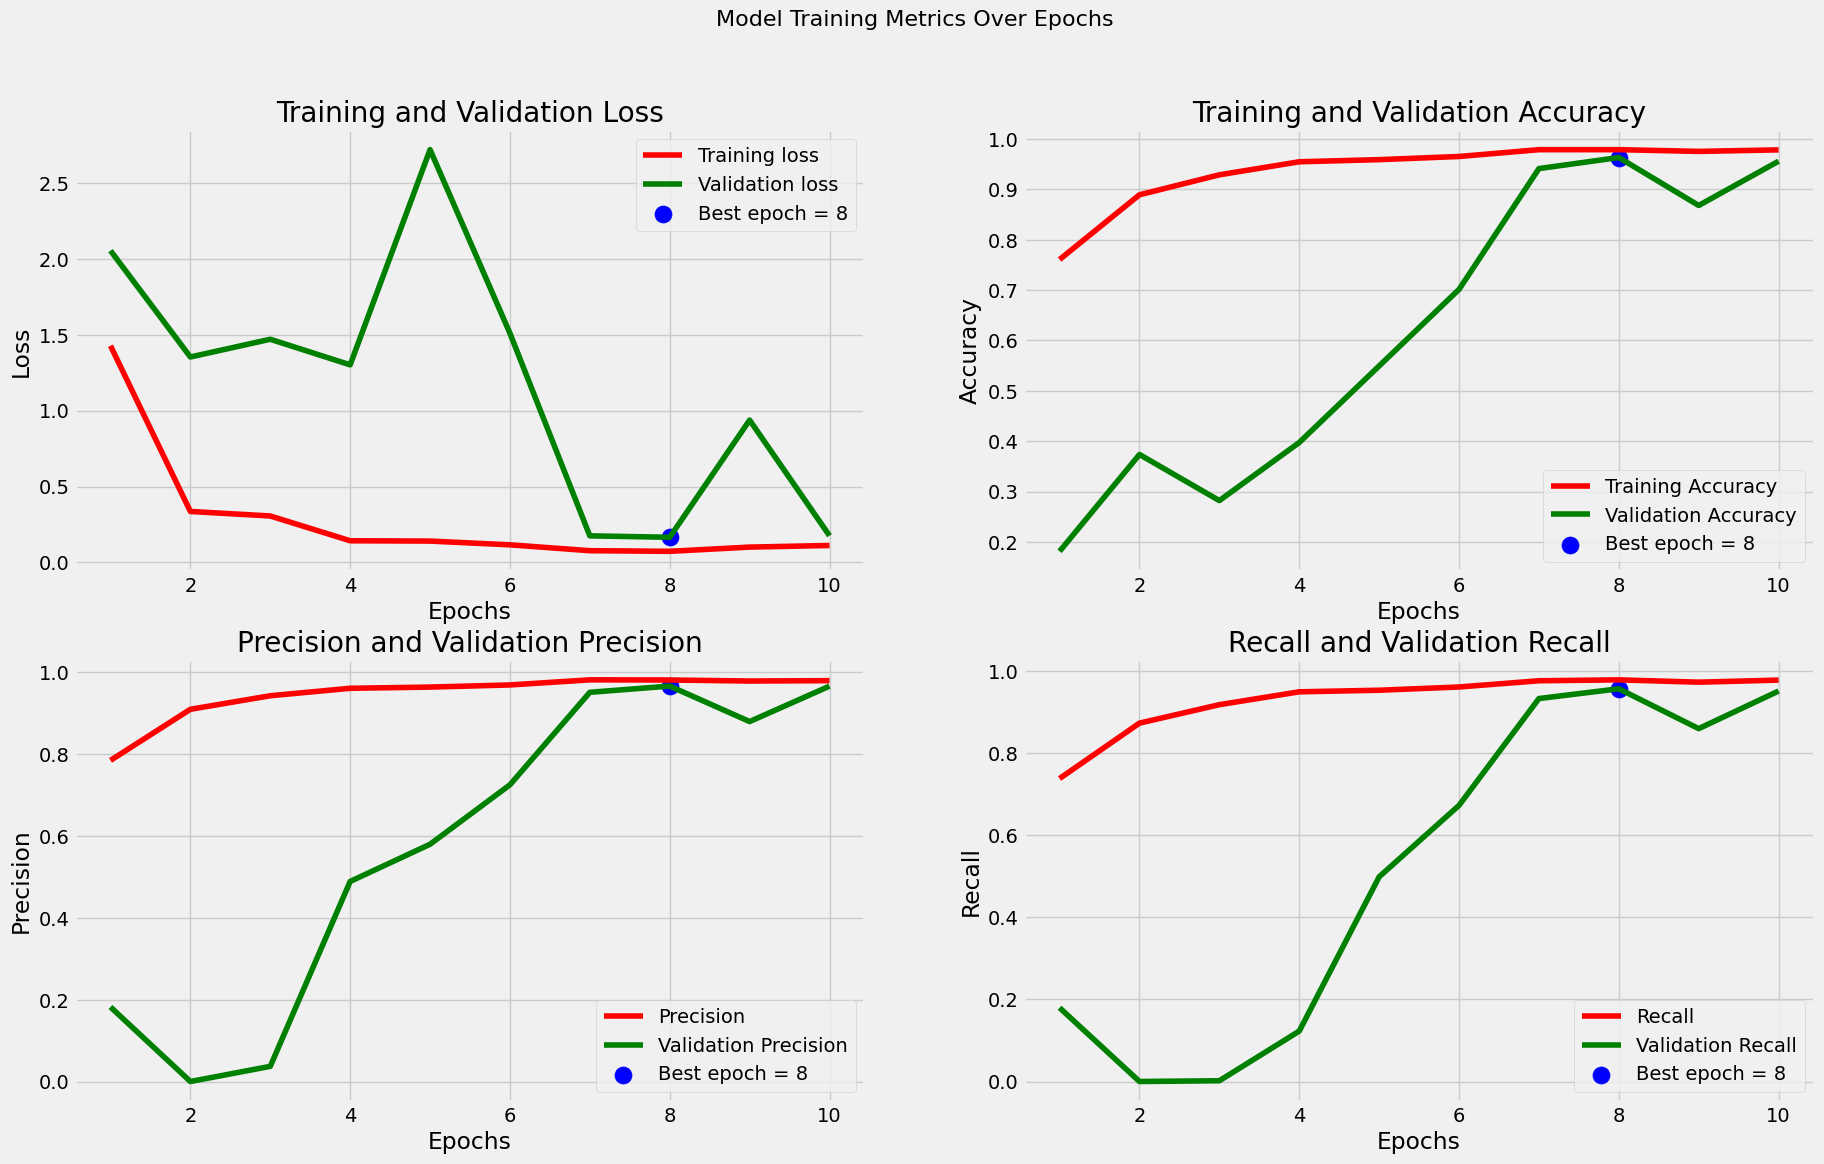

35/35 [==============================] - 1s 41ms/step - loss: 0.1050 - accuracy: 0.9689 - precision_3: 0.9723 - recall_3: 0.9652
Train Loss: 0.0429
Train Accuracy: 98.89%
--------------------
Validation Loss: 0.1857
Validation Accuracy: 94.87%
--------------------
Test Loss: 0.1050
Test Accuracy: 96.89%


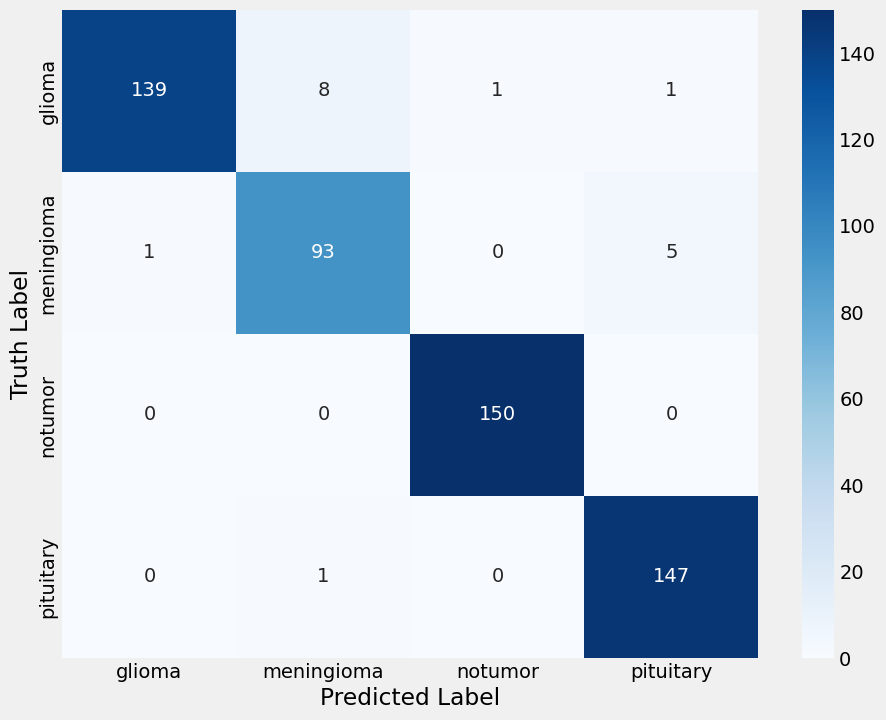

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       149
           1       0.91      0.94      0.93        99
           2       0.99      1.00      1.00       150
           3       0.96      0.99      0.98       148

    accuracy                           0.97       546
   macro avg       0.96      0.97      0.97       546
weighted avg       0.97      0.97      0.97       546



In [11]:

# Visualize model performance
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_3']
tr_recall = hist.history['recall_3']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_3']
val_recall = hist.history['val_recall_3']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Testing and Evaluation
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(tr_gen.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

clr = classification_report(ts_gen.classes, y_pred)
print(clr)